In [1]:
import os, shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw, ImageOps
import string
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,GlobalAveragePooling2D,BatchNormalization,Flatten, Dropout, Lambda, concatenate
from keras.models import Model
import pandas as pd
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50


from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Input, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing




In [2]:
np.random.seed(seed=123)

In [3]:
prints = list(string.printable)[0:84]
def gen_watermark(im_str, train = 1):
    img = Image.open("C:/Users/subha/Downloads/Compressed/VOCdevkit/VOC2008/JPEGImages/{}".format(im_str))
    img.save('E:/project1/inputdata/raw/{}'.format(im_str))
    font_size = np.random.randint(low = 20, high = 100)
    
    font = ImageFont.truetype("arial.ttf", font_size) 
    
    img_temp = Image.new('L', (350,350))
    
    text_str = np.random.choice(prints, np.random.randint(low=5, high = 10))
    text_str = "".join(text_str)
    
    draw_temp = ImageDraw.Draw(img_temp) 
    
    opac = np.random.randint(low=90, high=120)
    
    draw_temp.text((0, 0), text_str,  font=font, fill=opac)
    
    rot_int = np.random.randint(low = 0, high = 20)
    
    rotated_text = img_temp.rotate(rot_int,  expand=1)
    
    col_1 = (255,255,255)
    col_2 = (255,255,255)
    
    rand_loc = tuple(np.random.randint(low=10,high=100, size = (2,)))
    img.paste(ImageOps.colorize(rotated_text, col_1, col_2), rand_loc,  rotated_text)
    
    img.save('E:/project1/inputdata/water/{}'.format(im_str))

In [4]:
im_list = os.listdir("C:/Users/subha/Downloads/Compressed/VOCdevkit/VOC2008/JPEGImages")

#run time is about 5-6 minutes for all 5000 images:
for ind, img in enumerate(im_list):
    
    #add the watermark to the image and save to 'watered' directory
    wat_img = gen_watermark(img)

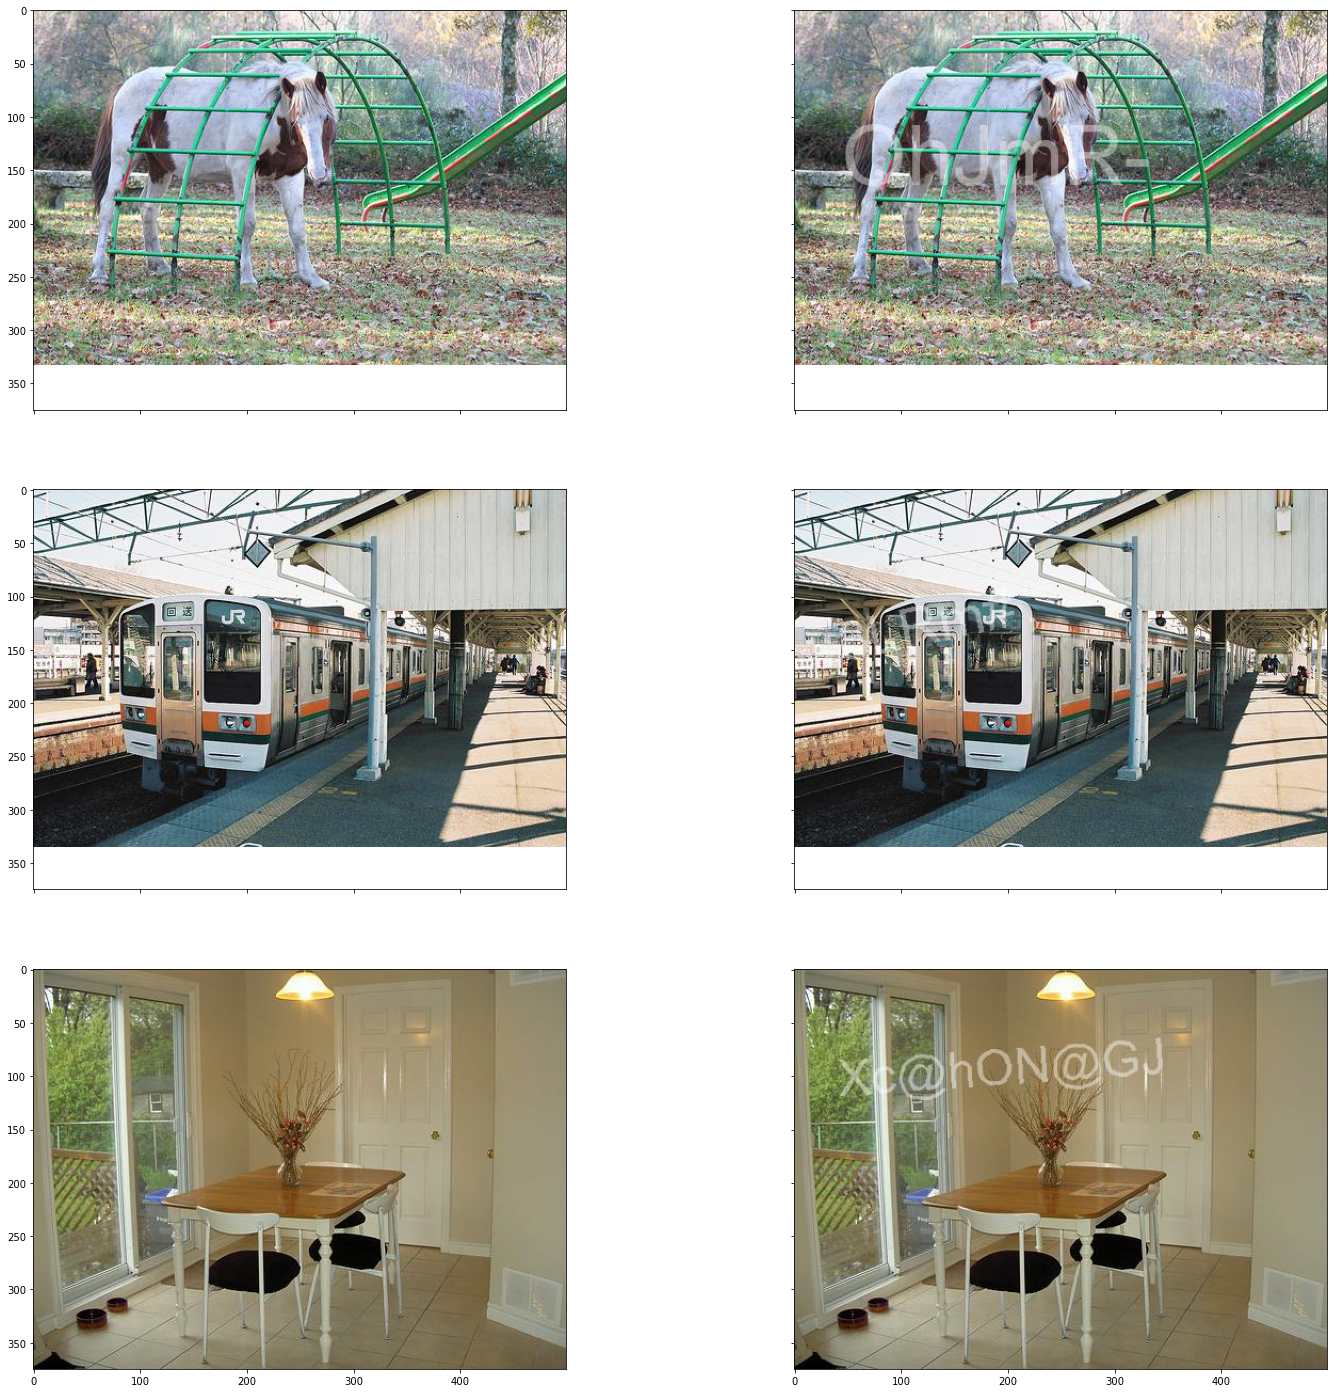

In [5]:
dir_raw = os.listdir("E:/project1/inputdata/raw")
dir_wats = os.listdir("E:/project1/inputdata/water")

#example: 
raw_str = "E:/project1/inputdata/raw/"
wat_str = "E:/project1/inputdata/water/"

f, axs = plt.subplots(3,2, figsize=(25, 25), sharey=True, sharex = True)
axs = axs.ravel()

img_raw = Image.open(raw_str + dir_raw[20])
img_wat = Image.open(wat_str + dir_wats[20])
axs[0].imshow(img_raw)
axs[1].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[40])
img_wat = Image.open(wat_str + dir_wats[40])
axs[2].imshow(img_raw)
axs[3].imshow(img_wat)

img_raw = Image.open(raw_str + dir_raw[60])
img_wat = Image.open(wat_str + dir_wats[60])
axs[4].imshow(img_raw)
axs[5].imshow(img_wat)

plt.show()

In [6]:
import splitfolders
input_folder='E:/project1/inputdata'
output='E:/project1/processeddata'
splitfolders.ratio(input_folder,output,seed=42,ratio=(.8,.1,.1))

Copying files: 10192 files [00:15, 654.62 files/s]


In [7]:
image_height,image_width=(224,224)
batch_size=16
train_data_dir='E:/project1/processeddata/train'
test_data_dir='E:/project1/processeddata/test'
val='E:/project1/processeddata/val'

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                 validation_split=0.2)

train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                 target_size=(image_height,image_width)
                                                 ,batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='training')

valid_generator=train_datagen.flow_from_directory(val,
                                                 target_size=(image_height,image_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='validation')

Found 6522 images belonging to 2 classes.
Found 610 images belonging to 2 classes.


In [9]:
test_generator=train_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(image_height,image_width)
                                                 ,batch_size=1,
                                                 class_mode='categorical',
                                                 subset='validation')

Found 408 images belonging to 2 classes.


In [10]:
x,y=test_generator.next()
x.shape

(1, 224, 224, 3)

In [11]:
base_model=ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu',input_dim=512)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(.4)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(.3)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(.2)(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
for layer in base_model.layers:
    layer.trainable=False
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])
hist=model.fit(train_generator,epochs=10,validation_data=valid_generator)

Epoch 1/10
408/408 [==============================] - 135s 311ms/step - loss: 0.6814 - accuracy: 0.5826 - val_loss: 0.5715 - val_accuracy: 0.7066
Epoch 2/10
408/408 [==============================] - 126s 308ms/step - loss: 0.5744 - accuracy: 0.6909 - val_loss: 0.5050 - val_accuracy: 0.7279
Epoch 3/10
408/408 [==============================] - 126s 310ms/step - loss: 0.5376 - accuracy: 0.7199 - val_loss: 0.4928 - val_accuracy: 0.7623
Epoch 4/10
408/408 [==============================] - 122s 300ms/step - loss: 0.5155 - accuracy: 0.7324 - val_loss: 0.4712 - val_accuracy: 0.7656
Epoch 5/10
408/408 [==============================] - 125s 306ms/step - loss: 0.4945 - accuracy: 0.7453 - val_loss: 0.4566 - val_accuracy: 0.7869
Epoch 6/10
408/408 [==============================] - 127s 310ms/step - loss: 0.4838 - accuracy: 0.7570 - val_loss: 0.4519 - val_accuracy: 0.7934
Epoch 7/10
408/408 [==============================] - 124s 304ms/step - loss: 0.4720 - accuracy: 0.7602 - val_loss: 0.4598 -

In [13]:
model.save('E:/project1/savedmodel/RestNet50_water.h5')

C:\Users\subha\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [14]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2,)
print("\n Test Accuracy",test_acc)

408/408 - 19s - loss: 0.4451 - accuracy: 0.7598

 Test Accuracy 0.7598039507865906


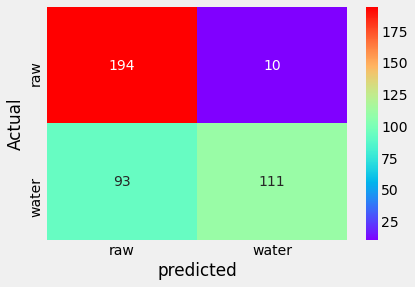

<Figure size 1440x1440 with 0 Axes>

Test Accuracy:74.75490196078431


In [43]:
import seaborn as sn
model=tf.keras.models.load_model('E:/project1/savedmodel/RestNet50_water.h5')
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    x_test,y_test=test_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)
predict_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]
out_df=pd.DataFrame(np.vstack([predict_class,actual_class]).T,columns=['predict_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predict_class'],rownames=['Actual'],colnames=['predicted'])
sn.heatmap(confusion_matrix,cmap='rainbow',annot=True,fmt='d')
plt.figure(figsize=(20,20))
plt.show()
print('Test Accuracy:{}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))


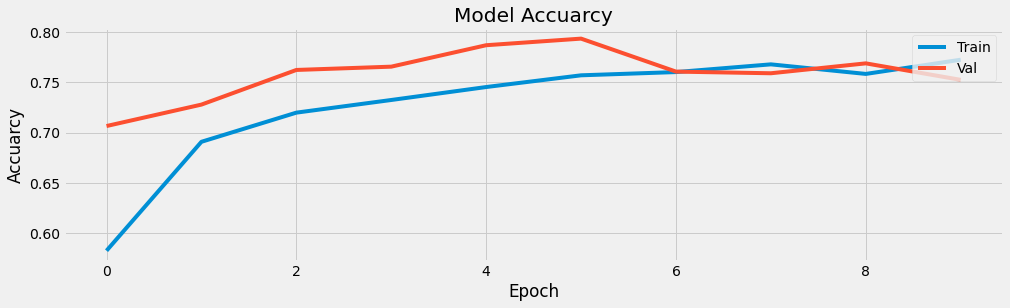

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,4))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuarcy')
plt.ylabel('Accuarcy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper right')
plt.show()

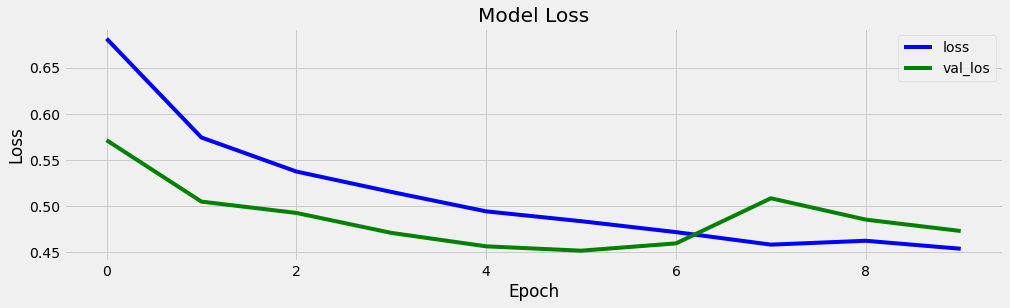

In [17]:
plt.figure(figsize=(15,4))
plt.plot(hist.history['loss'],color='blue')
plt.plot(hist.history['val_loss'],color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss','val_los'],loc='upper right')
plt.show()

In [18]:
#for cnn 

training=ImageDataGenerator(rescale=1/255)
validation=ImageDataGenerator(rescale=1/255)

In [19]:
train_dataset=training.flow_from_directory('E:/project/training',target_size=(200,200),batch_size=12,class_mode='binary')

validation_dataset=validation.flow_from_directory('E:/project/validation',target_size=(200,200),batch_size=12,class_mode='binary')

Found 10192 images belonging to 2 classes.
Found 577 images belonging to 2 classes.


In [20]:
model1=tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
                                  tf.keras.layers.MaxPooling2D(2, 2),
                                  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)),
                                  tf.keras.layers.MaxPooling2D(2, 2),
                                  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(200, 200, 3)),

                                  tf.keras.layers.Conv2D(100, (3, 3), activation='relu', input_shape=(200, 200, 3)),
                                  tf.keras.layers.MaxPooling2D(4, 4),
                                  tf.keras.layers.Conv2D(75, (3, 3), activation='relu', input_shape=(200, 200, 3)),
                                  tf.keras.layers.MaxPooling2D(2, 2),
                                  
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dropout(0.3),
                                  tf.keras.layers.Dense(202,activation='relu'),
                                  tf.keras.layers.Dropout(0.5),
                                  tf.keras.layers.Dense(40,activation='relu'),
                                  tf.keras.layers.Dense(1,activation='sigmoid')])
                                  

In [21]:
model1.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

In [23]:
model_fit=model1.fit(train_dataset,steps_per_epoch=3,epochs=20,validation_data=validation_dataset)

Epoch 1/20
3/3 [==============================] - 18s 7s/step - loss: 0.7325 - acc: 0.5833 - val_loss: 0.7043 - val_acc: 0.5875
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.6872 - acc: 0.5556 - val_loss: 0.6675 - val_acc: 0.5875
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.7278 - acc: 0.4167 - val_loss: 0.6987 - val_acc: 0.4125
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.6848 - acc: 0.6111 - val_loss: 0.6974 - val_acc: 0.4159
Epoch 5/20
3/3 [==============================] - 3s 2s/step - loss: 0.7124 - acc: 0.3611 - val_loss: 0.6904 - val_acc: 0.5875
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.6969 - acc: 0.4444 - val_loss: 0.6941 - val_acc: 0.4125
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.6916 - acc: 0.5000 - val_loss: 0.6940 - val_acc: 0.4281
Epoch 8/20
3/3 [==============================] - 3s 1s/step - loss: 0.7037 - acc: 0.4444 - val_loss: 0.6883 -

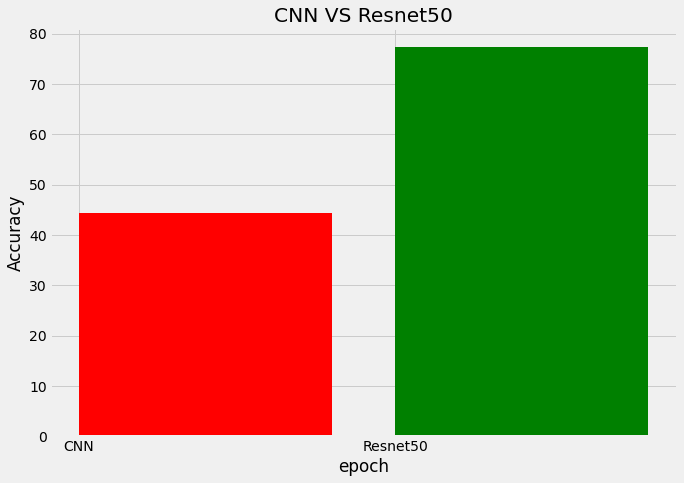

In [40]:
k=['CNN','Resnet50']
plt.figure(figsize=(10,7))
h=[44.45,77.25]
c=['red','green']
plt.bar(k,h,align='edge',color=c)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('CNN VS Resnet50')
plt.show()

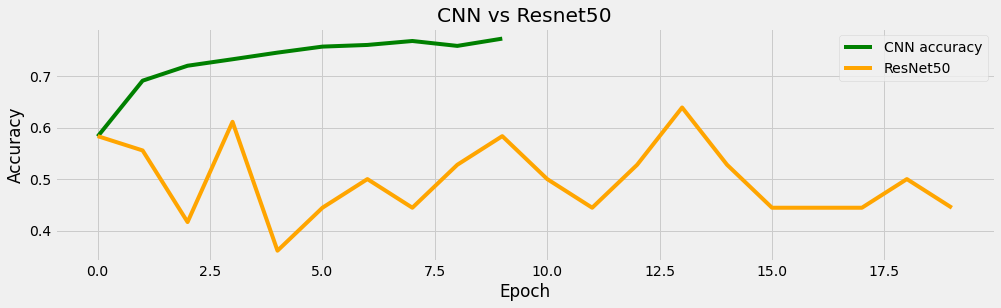